## 人脸与人脸关键点检测

在训练用于检测面部关键点的神经网络之后，你可以将此网络应用于包含人脸的*任何一个*图像。该神经网络需要一定大小的Tensor作为输入，因此，要检测任何一个人脸，你都首先必须进行一些预处理。

1. 使用人脸检测器检测图像中的所有人脸。在这个notebook中，我们将使用Haar级联检测器。
2. 对这些人脸图像进行预处理，使其成为灰度图像，并转换为你期望的输入尺寸的张量。这个步骤与你在Notebook 2中创建和应用的`data_transform` 类似，其作用是重新缩放、归一化，并将所有图像转换为Tensor，作为CNN的输入。
3. 使用已被训练的模型检测图像上的人脸关键点。

---

在下一个python单元格中，我们要加载项目此部分所需的库。

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
%matplotlib inline

#### 选择图像 

选择一张图像，执行人脸关键点检测。你可以在`images/`目录中选择任何一张人脸图像。

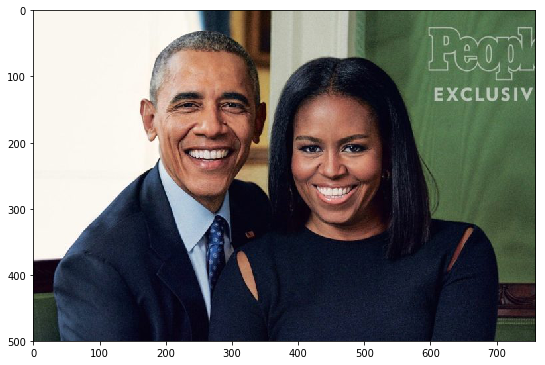

In [2]:
import cv2
# load in color image for face detection
image = cv2.imread('images/obamas.jpg')

# switch red and blue color channels 
# --> by default OpenCV assumes BLUE comes first, not RED as in many images
image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)

# plot the image
fig = plt.figure(figsize=(9,9))
plt.imshow(image)

## 检测该图像中的所有人脸

要想检测到所选图像中的所有人脸，接下来，你要用到的是OpenCV预先训练的一个Haar级联分类器，所有这些分类器都可以在`detector_architectures/`目录中找到。

在下面的代码中，我们要遍历原始图像中的每个人脸，并在原始图像的副本中的每个人脸上绘制一个红色正方形，而原始图像不需要修改。此外，你也可以 [新增一项眼睛检测 ](https://docs.opencv.org/3.4.1/d7/d8b/tutorial_py_face_detection.html) ，作为使用Haar检测器的一个可选练习。

下面是各种图像上的人脸检测示例。

<img src='images/haar_cascade_ex.png' width=80% height=80%/>

x: 179 y: 74 w: 174 h: 174
x: 371 y: 144 w: 160 h: 160


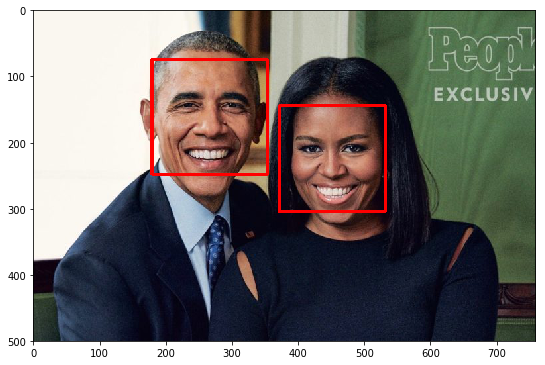

In [3]:
# load in a haar cascade classifier for detecting frontal faces
face_cascade = cv2.CascadeClassifier('detector_architectures/haarcascade_frontalface_default.xml')

# run the detector
# the output here is an array of detections; the corners of each detection box
# if necessary, modify these parameters until you successfully identify every face in a given image
faces = face_cascade.detectMultiScale(image, 1.2, 2)

# make a copy of the original image to plot detections on
image_with_detections = image.copy()

# loop over the detected faces, mark the image where each face is found
for (x,y,w,h) in faces:
    # draw a rectangle around each detected face
    # you may also need to change the width of the rectangle drawn depending on image resolution
    cv2.rectangle(image_with_detections,(x,y),(x+w,y+h),(255,0,0),3) 
    print('x:',x,'y:',y,'w:',w,'h:',h)

fig = plt.figure(figsize=(9,9))

plt.imshow(image_with_detections)

## 加载到已训练的模型中

有了一个可以使用的图像后（在这里，你可以选择`images/` 目录中的任何一张人脸图像），下一步是对该图像进行预处理并将其输入进CNN人脸关键点检测器。

首先，按文件名加载你选定的最佳模型。

In [5]:
import torch
from models import Net

net = Net()

## TODO: load the best saved model parameters (by your path name)
## You'll need to un-comment the line below and add the correct name for *your* saved model
# net.load_state_dict(torch.load('saved_models/keypoints_model_1.pt'))
net.load_state_dict(torch.load('saved_models/keypoints_model_2.pt'))

## print out your net and prepare it for testing (uncomment the line below)
net.eval()

Net(
  (conv1): Conv2d(1, 32, kernel_size=(4, 4), stride=(1, 1))
  (conv2): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1))
  (conv3): Conv2d(64, 128, kernel_size=(2, 2), stride=(1, 1))
  (conv4): Conv2d(128, 256, kernel_size=(1, 1), stride=(1, 1))
  (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (bn3): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (bn4): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (pool): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (dropout1): Dropout(p=0.1)
  (dropout2): Dropout(p=0.2)
  (dropout3): Dropout(p=0.3)
  (dropout4): Dropout(p=0.4)
  (dropout5): Dropout(p=0.5)
  (dropout6): Dropout(p=0.6)
  (fc1): Linear(in_features=43264, out_features=1000, bias=True)
  (fc2): Linear(in_features=1000, out_features=600, bias=True)
  (fc3): Linear(in_features=600, out_features=136, bias=True)
)

## 关键点检测

现在，我们需要再一次遍历图像中每个检测到的人脸，只是这一次，你需要将这些人脸转换为CNN可以接受的张量形式的输入图像。

### TODO: 将每个检测到的人脸转换为输入Tensor

你需要对每个检测到的人脸执行以下操作：
1. 将人脸从RGB图转换为灰度图
2. 把灰度图像归一化，使其颜色范围落在[0,1]范围，而不是[0,255]
3. 将检测到的人脸重新缩放为CNN的预期方形尺寸（我们建议为 224x224）
4. 将numpy图像变形为torch图像。

**提示**: Haar检测器检测到的人脸大小与神经网络训练过的人脸大小不同。如果你发现模型生成的关键点对给定的人脸来说，显得太小，请尝试在检测到的`roi`中添加一些填充，然后将其作为模型的输入。

你可能会发现，参看`data_load.py`中的转换代码对帮助执行这些处理步骤很有帮助。


### TODO: 检测并显示预测到的关键点

将每个人脸适当地转换为网络的输入Tensor之后，就可以将`net` 应用于每个人脸。输出应该是预测到的人脸关键点，这些关键点需要“非归一化”才能显示。你可能会发现，编写一个类似`show_keypoints`的辅助函数会很有帮助。最后，你会得到一张如下的图像，其中人脸关键点与每张人脸上的面部特征非常匹配：

<img src='images/michelle_detected.png' width=30% height=30%/>

image.shape: (500, 759, 3)
x: 179 y: 74 w: 174 h: 174
x: 371 y: 144 w: 160 h: 160


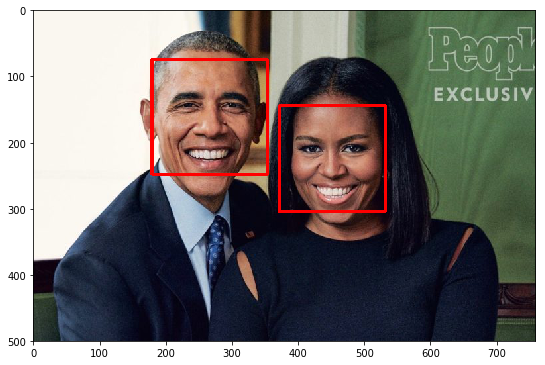

In [6]:
# load in a haar cascade classifier for detecting frontal faces
face_cascade = cv2.CascadeClassifier('detector_architectures/haarcascade_frontalface_default.xml')
print('image.shape:',image.shape)
faces = face_cascade.detectMultiScale(image, 1.2, 2)
image_with_detections = image.copy()
for (x,y,w,h) in faces:
    cv2.rectangle(image_with_detections,(x,y),(x+w,y+h),(255,0,0),3) 
    print('x:',x,'y:',y,'w:',w,'h:',h)

fig = plt.figure(figsize=(9,9))

plt.imshow(image_with_detections)

roi.shape: (224, 224, 3)


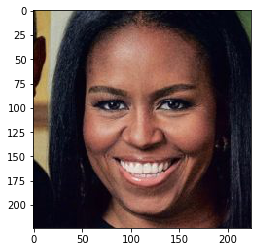

In [9]:
image_copy = np.copy(image)

# loop over the detected faces from your haar cascade
for (x,y,w,h) in faces:
    roi = image_copy[y-32:y+32+h, x-32:x+32+w]
print('roi.shape:',roi.shape) 
plt.imshow(roi)    

In [14]:
def show_all_keypoints(image, predicted_key_pts):
    """Show image with predicted keypoints"""
    # image is grayscale
    plt.imshow(image, cmap='gray')
    plt.scatter(predicted_key_pts[:, 0], predicted_key_pts[:, 1], s=10, marker='.', c='r')

def visualize_output(test_images, test_outputs):
    plt.figure(figsize=(5,5))
    image = test_images.data   # get the image from it's Variable wrapper
    image = image.numpy()   # convert to numpy array from a Tensor
    image = np.transpose(image, (1, 2, 0))   # transpose to go from torch to numpy image

    # un-transform the predicted key_pts data
    predicted_key_pts = test_outputs.data
    predicted_key_pts = predicted_key_pts.numpy()
    # undo normalization of keypoints  
    predicted_key_pts = predicted_key_pts*50.0+100

    # call show_all_keypoints
    show_all_keypoints(np.squeeze(image), predicted_key_pts)

    plt.axis('off')

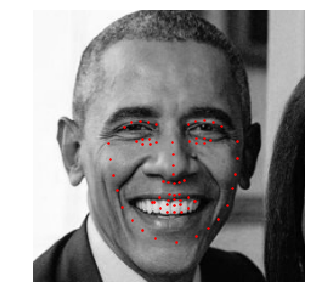

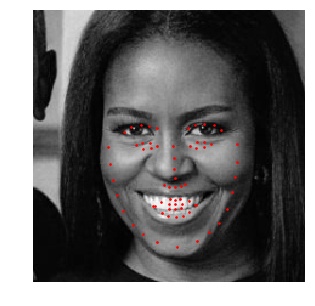

In [15]:
image_copy = np.copy(image)

# loop over the detected faces from your haar cascade
for (x,y,w,h) in faces:
    
    # Select the region of interest that is the face in the image 
    roi_copy = image_copy[y-40:y+40+h, x-40:x+40+w]
    
    ## TODO: Convert the face region from RGB to grayscale
    roi_gray = cv2.cvtColor(roi_copy, cv2.COLOR_BGR2GRAY)
    ## TODO: Normalize the grayscale image so that its color range falls in [0,1] instead of [0,255]
    roi_gray = roi_gray / 255.0
    
    ## TODO: Rescale the detected face to be the expected square size for your CNN (224x224, suggested)
    #roi.shape: (224, 224, 1)
    roi = cv2.resize(roi_gray, (224, 224)).reshape(224, 224, 1)
    
    ## TODO: Reshape the numpy image shape (H x W x C) into a torch image shape (C x H x W)\
    # roi_torch1.shape: 1*224*224
    roi_torch = torch.from_numpy(roi.transpose(2, 0, 1))
    
    ## TODO: Make facial keypoint predictions using your loaded, trained network 
    ## perform a forward pass to get the predicted facial keypoints
    roi_torch = roi_torch.type(torch.FloatTensor)
    
    # roi_torch2.shape:  1*1*224*224 
    roi_torch2 = roi_torch.unsqueeze(0) 
    predicted_key_pts = net(roi_torch2)
    predicted_key_pts = predicted_key_pts.view( 68, -1)
    ## TODO: Display each detected face and the corresponding keypoints
    plt.show()
    visualize_output(roi_torch, predicted_key_pts)